<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 2 Unsupervised Text Classification

## 2.0 Import libraries

1. [Gensim](https://radimrehurek.com/gensim/index.html) - is primarily a Python Topic Modelling library. It also has lots of useful features for working with Word Vectors.

In [1]:
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data/imdb)
data_dir = os.path.join(path, 'data', 'imdb')

# Set the directory to the shared dataset folder (should be in shared/datasets/imdb)
dataset_dir = os.path.join(path, '..', 'shared', 'datasets', 'imdb')

# Set the directory to the shared models folder (should be in shared/models/imdb)
model_dir = os.path.join(path, '..', 'shared', 'models', 'imdb')

# Load the Spacy language model ('en_core_web_md' should be in shared/models/spacy)
nlp = spacy.load(os.path.join(path, '..', 'shared', 'models', 'spacy'))

2025-02-16 11:47:38.938888: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.1 Load and pre-process data

In [2]:
# Load the imdb dataset
imdb_dataset = pd.read_csv(os.path.join(dataset_dir, 'imdb_dataset.csv'))

# Load your imdb reviews
imdb_reviews = pd.read_csv(os.path.join(data_dir, 'imdb_reviews.csv'))

# Convert the sentiment to a binary value
imdb_dataset['sentiment'] = pd.get_dummies(imdb_dataset['sentiment'], drop_first=True)
imdb_reviews['sentiment'] = pd.get_dummies(imdb_reviews['sentiment'], drop_first=True)

imdb_reviews.head()

,review,sentiment
0,there is a new nuclear arms race underway supe...,0
1,superman iv the quest for peace is a good movi...,0
2,very odd and very short color film that tries ...,1
3,the acting costumes and dialog for monsters cr...,1
4,while the batman franchise has been much malig...,1


### Process and vectorise the text

Unlike our application of Naive Bayes and ANN, for clustering we need to change our input representations and consider two things:
- **Zero values** - in Naive Bayes these simply result in low probability and in an ANN inputs of 0 will not impact weight updates.
- **Common words** - these *may* have less impact on the probabilistic and ANN approach, but for clustering, since we are calculating the distance/similarity between examples, lots of common but uninformative words will tend to make examples appear closer/more similar.

1. We will use sklearn's `TfidfVectorizer()` to tokenise the text and vectorise each review into a TF-IDF values. This should reduce the magnitude of very common words, which are unlikely to provide sentiment information. We will also remove english stop words and ensure a minimum and maximum word frequency.

2. To avoid zeros within the input, and enhance important words, we will also scale the TF-IDF values.

3. Next use PCA to select only the most important features. Here we use 2 so that the clusters can be plotted in 2D.

2. Finally, split into training and validation sets. Use your IMDB reviews as the test set.

In [3]:
# Set the vocab size
vocab_size = 2000

# Create a TfidfVectorizer, StandardScaler and PCA
tfidf_vectoriser = TfidfVectorizer(max_features=vocab_size, stop_words='english', max_df=0.95, min_df=2)
scaler = StandardScaler()
pca = PCA(n_components=2)

# Vectorise the text
X = tfidf_vectoriser.fit_transform(imdb_dataset['review']).toarray()
X = scaler.fit_transform(X)
X = pca.fit_transform(X)
print(f'Shape of X: {X.shape}')
print(X[:5, :])

# Get the class labels
y = imdb_dataset['sentiment'].values
print(f'Shape of y: {y.shape}')
print(y[:5])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorise the text the test set
X_test = tfidf_vectoriser.transform(imdb_reviews['review']).toarray()
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

# Get the class labels
y_test = imdb_reviews['sentiment'].values

Shape of X: (50000, 2)
[[-1.23859259  1.9976709 ]
 [-2.26309847 -1.81417516]
 [-0.25645778 -1.70394572]
 [ 0.71984762  0.67388237]
 [-2.75953729 -0.83990711]]
Shape of y: (50000,)
[1 1 1 0 1]


## 2.2 K-means

K-means is a clustering algorithm which defines a set of centroids (mid-points) for each cluster.

Examples are assigned to the closest cluster/centroid. Centroids are repeatedly moved to a new mid-point of all examples in the cluster, until no further changes are made.

Pseudocode:
```
Set K number of centroids and randomly assign to examples
Set converged = False

WHILE not converged:
	For each example i:
		For each cluster k:
			Calculate distance(i, k)
		Assign i to cluster with smallest distance
	
	IF no examples moved cluster:
		converged = True
	ELSE:
		For each cluster k:
			SET new cluster centroid = average position of examples in cluster
```

### Train and evaluate the model

Validation Accuracy: 0.6419


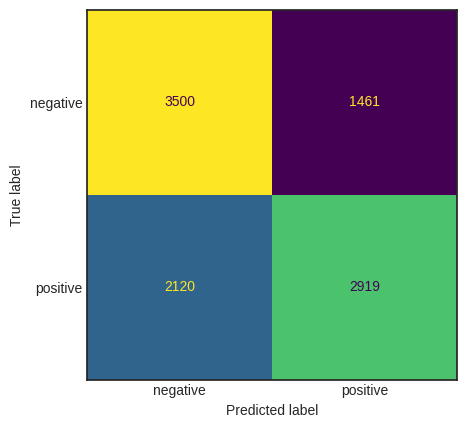

In [5]:
if not grading:
    # Create and train a Kmeans
    kmeans = KMeans(n_clusters=2, n_init=1, init='random', random_state=42)
    kmeans.fit(X_train)
    
    # Predict class labels for validation set
    predictions = kmeans.predict(X_val)
    print(f'Validation Accuracy: {accuracy_score(y_val, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

### Evaluate the model on your IMDB reviews

Test Accuracy: 0.56


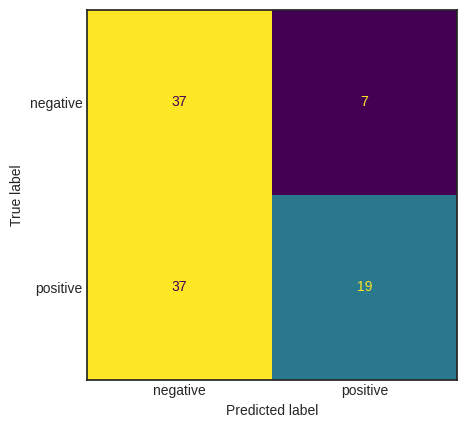

In [5]:
if not grading:
    # Predict class labels for test set
    predictions = kmeans.predict(X_test)
    print(f'Test Accuracy: {accuracy_score(y_test, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

### Plot the decision boundary, cluster centroids and validation and test datapoints

Code for plotting is adapted from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py).

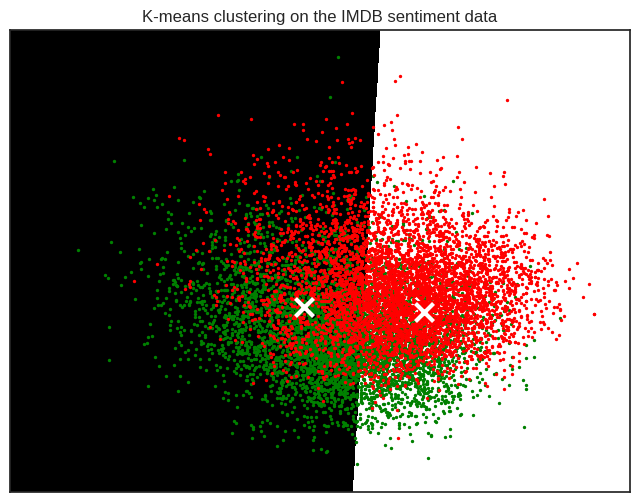

In [6]:
if not grading:
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.01  # point in the mesh [x_min, x_max]x[y_min, y_max].
    
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh using trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
    )
    
    # Plot the validation and test data only
    points = np.concatenate((X_val, X_test))
    labels =  np.concatenate((y_val, y_test))
    
    pos_points = np.array([list(points[i]) for i in range(len(points)) if labels[i] == 1])
    neg_points = np.array([list(points[i]) for i in range(len(points)) if labels[i] == 0])
    
    plt.scatter(pos_points[:, 0], pos_points[:, 1], color="green", s=2)
    plt.scatter(neg_points[:, 0], neg_points[:, 1], color="red", s=2)
    
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    
    plt.title("K-means clustering on the IMDB sentiment data")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

## 2.3 Semantic Similarity

We can use semantic representation of word embeddings to build a simple classifier using a heuristic approach.

1. Start with a list(s) of words that are representative of the categories e.g. ‘good’ and ‘bad’ for sentiment.

    - Optionally, find other similar words within the corpus using cosine similarity.

2. Score each word in an input example according to its similarity to each word in the category lists.

3. Average the word scores to produce semantic scores for each category.

4. Make predictions based on the category with the highest semantic score.

### Process the text

Just tokenise and remove stop words.

In [6]:
# Load the imdb dataset and tokenise the reviews
X = imdb_dataset['review'].apply(lambda x: [token.text for token in nlp.tokenizer(x) if not token.is_stop])
y = imdb_dataset['sentiment'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Load your imdb reviews and tokenise the reviews
X_test = imdb_reviews['review'].apply(lambda x: [token.text for token in nlp.tokenizer(x) if not token.is_stop])
y_test = imdb_reviews['sentiment'].values

### Create a Word2Vec model

We will use gensim to load [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) embeddings and fine tune to our corpus of IMDB reviews.

- `vector_size` is the size of the embedding.
- `window` is the maximum distance between the current and predicted word within a sentence.
- `min_count` all words with total frequency lower than this are ignored.
- `sg` is the training algorithm: 1 for skip-gram or 0 for CBOW.
- `epochs` is the number of training epochs for the model.

<div class="alert alert-danger" style="color:black"><b>Warning:</b><br>
Training the Word2Vec model can take a few minutes. To save time, and for consistency in testing, a model has been trained and saved beforehand. The code commented out below shows how the model can be trained and saved.
</div>

In [8]:
# Create a word2vec model with gensim
embedding_dim = 300

# Train the word2vec model
# w2v_model = Word2Vec(sentences=X_train, vector_size=embedding_dim, window=5, min_count=2, sg=1, epochs=3, seed=42, workers=4)
# w2v_model.save(os.path.join('imdb_w2v.model'))

# Load the word2vec model (to save time)
w2v_model = Word2Vec.load(os.path.join(model_dir, 'imdb_w2v.model'))

print(f"Word2Vec vocabulary: {list(w2v_model.wv.key_to_index)[:20]}")
print(f"Vocabulary size: {len(list(w2v_model.wv.key_to_index))}")

Word2Vec vocabulary: ['movie', 'film', 's', 'like', 'good', 'time', 'story', 'bad', 'people', 'great', 'way', 'movies', 'think', 'characters', 'watch', 'character', 'films', 'seen', 'plot', 'love']
Vocabulary size: 57308


### Create a list of positive and negative sentiment words

In [9]:
# Start with a selection of positive and negative words
pos_words = ['excellent', 'awesome', 'cool', 'decent', 'amazing', 'strong', 'good', 'great', 'funny', 'entertaining']
neg_words = ['terrible', 'awful', 'horrible', 'boring', 'bad', 'disappointing', 'weak', 'poor', 'senseless', 'confusing']

# Get the most similar words for each word in the positive and negative lists
pos_sims = w2v_model.wv.most_similar(pos_words, topn=10)
print(f'Positive similar words: {pos_sims}')

neg_sims = w2v_model.wv.most_similar(neg_words, topn=10)
print(f'Negative similar words: {neg_sims}')

# Get the vectors for each word in the positive and negative lists
pos_words.extend([word for word, score in pos_sims])
pos_vectors = np.array([w2v_model.wv.get_vector(word) for word in pos_words])

neg_words.extend([word for word, score in neg_sims])
neg_vectors = np.array([w2v_model.wv.get_vector(word) for word in neg_words])

Positive similar words: [('excel', 0.8718186020851135), ('recomend', 0.8680331707000732), ('outdone', 0.867475688457489), ('workable', 0.8643808364868164), ('definetly', 0.8601797819137573), ('adore', 0.858291745185852), ('shitty', 0.8567265868186951), ('spades', 0.8558498620986938), ('dis', 0.8523039221763611), ('cred', 0.8522864580154419)]
Negative similar words: [('appallingly', 0.9179584383964539), ('horrendously', 0.901282012462616), ('forgivable', 0.8988938331604004), ('woeful', 0.8979597091674805), ('dreadfully', 0.8926876187324524), ('substandard', 0.8923049569129944), ('subpar', 0.8899902105331421), ('redundant', 0.8886831402778625), ('hideously', 0.8885680437088013), ('deplorable', 0.8883354663848877)]


### Calculate the semantic score of each review<

Now that we have a Word2Vec model trained on the IMDB data and a list of positive and negative words, we can create a simple semantic similarity classifier.

1. The following cell implements the `semantic_similarity()` function. It takes in the following arguments and return a list of predictions and scores:
    - `data` is a list of tokenised reviews to be classified.
    - `model` is the trained Word2Vec model created above.
    - `pos_vectors` is the list of word vectors for the *positive* words created above.
    - `neg_vectors` is the list of word vectors for the *negative* words created above.

2. The function loops through each review and:
    - Converts the tokens to vectors using `model.wv.key_to_index` to check if the word is in the models vocabulary.
    - Calculates the positive and negative score for the review by the similarity to the positive and negative vectors.
    - Assign a class label: 1 if the average positive scores are > the average negative score, and 0 otherwise.

3. Finally returns the predictions for each review and an array of score (positive and negative), for each review.


In [10]:
def semantic_similarity(data, model, pos_vectors, neg_vectors):
    """Calculate the semantic similarity for each document.
    Arguments:
        data (list): A list of tokenised documents
        model (Word2Vec): A trained Word2Vec model
        pos_vectors (list): A list of positive word vectors
        neg_vectors (list): A list of negative word vectors
    """
    # Create an array to store the semantic similarity predictions
    predictions = np.zeros((len(data), 1))

    # Create an array to store the positive and negative scores
    scores = np.zeros((len(data), 2))

    # Loop through each document
    for i, review in enumerate(data):

        # Get the word vectors for the review
        review_vec = [model.wv.get_vector(word) for word in review if word in model.wv.key_to_index]

        # Calculate the cosine similarity between the positive and negative words and the review
        pos_scores = cosine_similarity(review_vec, pos_vectors)
        neg_scores = cosine_similarity(review_vec, neg_vectors)

        # Add to the average scores to the array
        scores[i, 0] = np.mean(pos_scores)
        scores[i, 1] = np.mean(neg_scores)

    # Make a prediction based on the average scores
    predictions = np.argmax(-scores, axis=1)

    return predictions, scores

### Predict sentiment labels according to category with the highest score

Validation Accuracy: 0.629


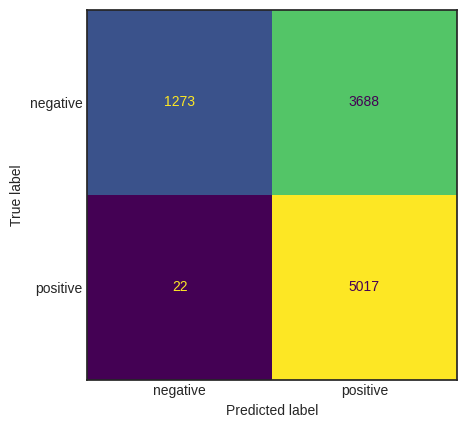

In [11]:
if not grading:
    # Predict class labels for validation set
    predictions, scores = semantic_similarity(X_val, w2v_model, pos_vectors, neg_vectors)
    print(f'Validation Accuracy: {accuracy_score(y_val, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

### Evaluate the model on your IMDB reviews

Test Accuracy: 0.61


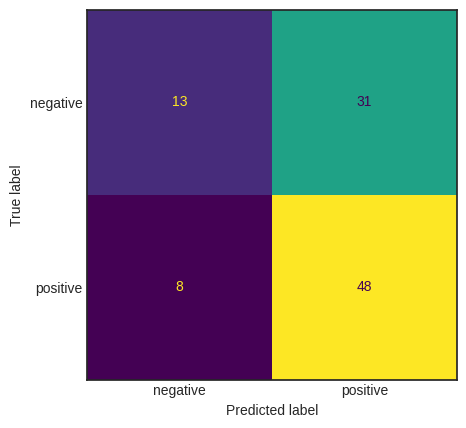

In [12]:
if not grading:
    # Predict class labels for test set
    predictions, scores = semantic_similarity(X_test, w2v_model, pos_vectors, neg_vectors)
    print(f'Test Accuracy: {accuracy_score(y_test, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280
